## ABM Covid-19 mitigation policies tutorial

In [1]:
from mhm.model import Model
from mhm import create_empty_hypotheses
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pd.set_option('display.max_columns', None)
np.random.seed(0)
dir_params = '../parameters/'

# Create empty matrices in `dir_params` folder

Store in the `dir_params` directory folder templates of the matrices. The templates are all empty (i.e., made of 0s) and serve the purpose of providing a ready-to-be-filled guide for the user to specify their hypotheses about both the type of lockdown, and the effects of each action on the mental health and number of contacts.

In [2]:
create_empty_hypotheses(dir_params)

### Initialize agents with some example hypotheses

For demonstration purposes, we load now from the `parameters_example` directory folder the matrices containing some of the hypotheses that we have made up. We also specify a population made of 100 agents.

### Initialise the model and generate 100 individuals

In [3]:
model = Model()

In [24]:
size = 10
individuals = model.setup(size, '../parameters_example/')

In [21]:
lockdowns = ['absent', 'easy', 'medium', 'hard']
steps = 10
# at the moment we are randomising it but ideally one should give the sequence of lockdowns for each step
repeated_entries = lockdowns * (steps // len(lockdowns)) + lockdowns[:steps % len(lockdowns)]
randomised_lockdowns = random.sample(repeated_entries, len(repeated_entries))

In [22]:
model.run(steps=steps, lockdown=randomised_lockdowns, out_path="out.csv")

### Run the model

This will output "simulation_results.csv". You can define the type of lockdown (among "hard", "easy", "medium", "no_lockdown") for each number of steps.

In [5]:
lockdowns = ['absent', 'easy', 'medium', 'hard']
steps = 10
# at the moment we are randomising it but ideally one should give the sequence of lockdowns for each step
repeated_entries = lockdowns * (steps // len(lockdowns)) + lockdowns[:steps % len(lockdowns)]
randomised_lockdowns = random.sample(repeated_entries, len(repeated_entries))

In [28]:
model.run(steps=steps, lockdown=randomised_lockdowns, out_path="simulation_results.csv")

In [29]:
data = pd.read_csv('simulation_results.csv')

### Group by step_id and compute the average mh and n_contacts

In [30]:
display(data.head())

,step_id,agent_id,lockdown,mh,n_contacts
0,0,0,easy,-1.5,5.1
1,0,1,easy,-2.0,2.8
2,0,2,easy,5.5,5.5
3,0,3,easy,9.0,4.6
4,0,4,easy,3.0,7.6


In [31]:
grouped_data = data.groupby('lockdown').mean()[['mh', 'n_contacts']]

In [32]:
grouped_data = data.groupby(['step_id', 'lockdown']).mean().reset_index()
display(grouped_data.head())

,step_id,lockdown,agent_id,mh,n_contacts
0,0,easy,4.5,4.90,6.48
1,1,hard,4.5,2.95,5.52
2,2,medium,4.5,3.65,4.71
3,3,easy,4.5,5.00,6.74
4,4,absent,4.5,3.25,5.50


### Create a scatter plot of the average mh and n_contacts for each step coloured by lockdown type

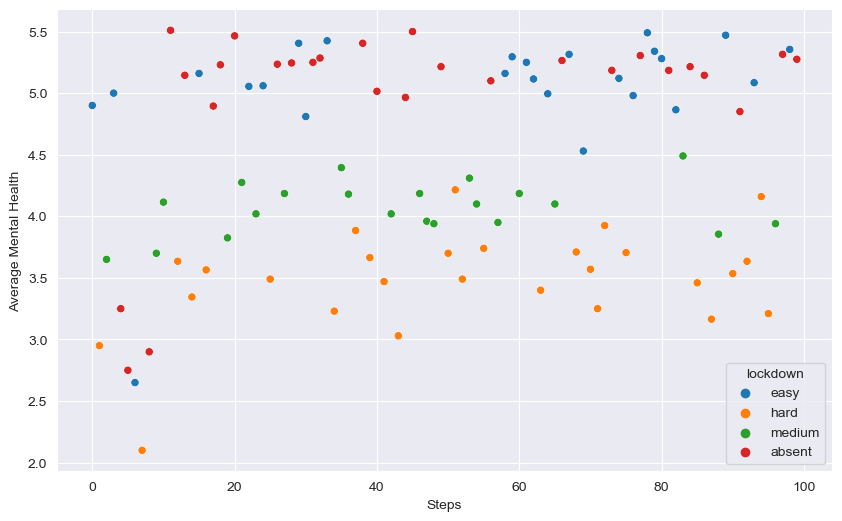

In [33]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=grouped_data, x='step_id', y='mh', hue='lockdown')
plt.xlabel('Steps')
plt.ylabel('Average Mental Health')
plt.show()

In [34]:
data.groupby(['lockdown']).mean().reset_index()

,lockdown,step_id,agent_id,mh,n_contacts
0,absent,50.358025,48.944444,5.188889,5.840494
1,easy,60.219731,48.894619,5.148655,5.763901
2,hard,56.817460,49.142857,3.559127,4.064841
3,medium,47.453125,49.031250,4.102344,5.130573


#### Average mental health by lockdown type

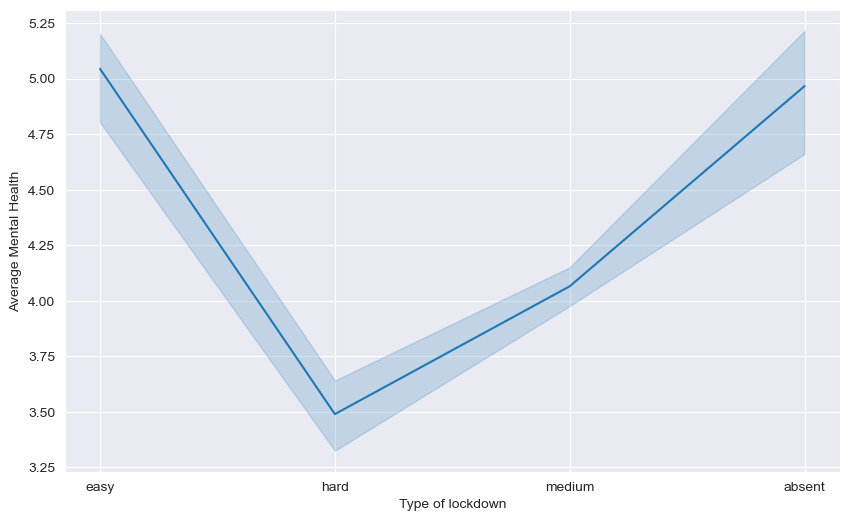

In [35]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=grouped_data, x="lockdown", y="mh")
plt.xlabel('Type of lockdown')
plt.ylabel('Average Mental Health')
plt.show()